# **Practical Work 4 - Exercise 1 (Basic GA)**
Done By: Hugo Cisneros, Javier de Santos, Alicia García and Fernando Teba

## **Libraries and Imports**

In [ ]:
import concurrent.futures
import time
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
import pickle
from google.colab import files
import os

In [ ]:
num_cores = os.cpu_count()
print(f'Number of CPU cores: {num_cores}')

Number of CPU cores: 8


## **Functions in the notebook**

In [ ]:
def calculate_coverage(grid, antennas):
    # Create a boolean grid initialized to False
    coverage = np.zeros(grid, dtype=bool)
    radius = 5  # Radius of 5 cells (0.5 km, as each cell represents 100m)

    # Iterate over each antenna
    for antenna in antennas:
        x, y = antenna
        # Iterate over the area within the radius around the antenna
        for i in range(max(0, x - radius), min(grid[0], x + radius + 1)):
            for j in range(max(0, y - radius), min(grid[1], y + radius + 1)):
                # Check if the cell is within the Euclidean distance radius
                if np.sqrt((x - i)**2 + (y - j)**2) <= radius:
                    coverage[i, j] = True
    return coverage

def calculate_coverage_manhattan(grid, antennas):
    # Create a boolean grid initialized to False
    coverage = np.zeros(grid, dtype=bool)
    radius = 5  # Radius of 5 cells (0.5 km, as each cell represents 100m)

    # Iterate over each antenna
    for antenna in antennas:
        x, y = antenna
        # Iterate over the area within the radius around the antenna
        for i in range(max(0, x - radius), min(grid[0], x + radius + 1)):
            for j in range(max(0, y - radius), min(grid[1], y + radius + 1)):
                # Check if the cell is within the Manhattan distance radius
                if abs(x - i) + abs(y - j) <= radius:
                    coverage[i, j] = True
    return coverage

def fitness_function(grid, antennas, distance_method='euclidean'):
    # Calculate coverage based on the specified distance method
    if distance_method == 'manhattan':
        coverage = calculate_coverage_manhattan(grid, antennas)
    else:
        coverage = calculate_coverage(grid, antennas)

    num_antennas = len(antennas)
    coverage_area = np.sum(coverage)
    # Return coverage area and number of antennas (to be used for selection)
    return coverage_area, num_antennas


def generate_population(grid, size):
    population = []
    for _ in range(size):
        # Generate a random number of antennas between 10 and 1000
        num_antennas = random.randint(10, 1000)
        # Generate random coordinates for each antenna
        antennas = [(random.randint(0, grid[0]-1), random.randint(0, grid[1]-1)) for _ in range(num_antennas)]
        population.append(antennas)
    return population


def select(population, fitnesses):
    total_fitness = sum(f[0] for f in fitnesses)
    # Select individuals from the population based on their fitness
    selected = random.choices(population, weights=[f[0] for f in fitnesses], k=len(population))
    return selected

def crossover(parent1, parent2):
    if len(parent1) > 1 and len(parent2) > 1:
        # Perform crossover at a random point
        point = random.randint(1, min(len(parent1), len(parent2))-1)
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]
    else:
        # If crossover cannot be done due to small size, return parents as children
        child1, child2 = parent1, parent2
    return child1, child2

def mutate(antennas, grid, mutation_rate):
    if random.random() < mutation_rate:
        if random.random() > 0.5 and len(antennas) > 1:
            # Remove a random antenna
            antennas.pop(random.randint(0, len(antennas)-1))
        else:
            # Add a new random antenna
            antennas.append((random.randint(0, grid[0]-1), random.randint(0, grid[1]-1)))
    return antennas


def genetic_algorithm(grid, population_size, generations, mutation_rate, distance_method='euclidean'):
    # Generate initial population
    population = generate_population(grid, population_size)
    best_solution = None
    best_fitness = (-1, float('inf'))  # Initialize to worst case (no coverage, infinite antennas)
    fitness_history = []

    for generation in range(generations):
        # Calculate fitness for each individual in the population
        fitnesses = [fitness_function(grid, ind, distance_method) for ind in population]
        # Find the best fitness in the current generation
        best_in_gen = max(fitnesses, key=lambda f: (f[0], -f[1]))

        if best_in_gen > best_fitness:
            best_fitness = best_in_gen
            best_solution = population[fitnesses.index(best_fitness)]

        fitness_history.append(best_fitness)

        # Select individuals for the next generation
        selected = select(population, fitnesses)
        new_population = []

        # Create new population through crossover and mutation
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutate(child1, grid, mutation_rate))
            new_population.append(mutate(child2, grid, mutation_rate))

        population = new_population

    return best_solution, best_fitness, fitness_history


def run_experiment_with_distance(grid, population_size, generations, mutation_rate, run, distance_method):
    start_time = time.time()
    # Run the genetic algorithm with the specified distance method
    best_solution, best_fitness, fitness_history = genetic_algorithm(grid, population_size, generations, mutation_rate, distance_method)
    end_time = time.time()
    run_time = end_time - start_time
    return {
        'generations': generations,
        'mutation_rate': mutation_rate,
        'run': run,
        'best_solution': best_solution,
        'best_fitness': best_fitness,
        'fitness_history': fitness_history,
        'run_time': run_time,
        'distance_method': distance_method
    }

def run_experiments_with_distance(grid, population_size, generations_list, mutation_rates, num_runs=3):
    results = []

    for generations in generations_list:
        for mutation_rate in mutation_rates:
            for run in range(num_runs):
                for distance_method in ['euclidean', 'manhattan']:
                    # Run experiments with both Euclidean and Manhattan distances
                    result = run_experiment_with_distance(grid, population_size, generations, mutation_rate, run, distance_method)
                    results.append(result)
                    print(f"Generations: {generations}, Mutation Rate: {mutation_rate}, Run: {run}, Distance Method: {distance_method}, Best Fitness: {result['best_fitness']}, Time: {result['run_time']:.2f} seconds")
    return results


In [ ]:
def run_experiments(grid, population_size, generations_list, mutation_rates, num_runs=3):
    results = []

    for generations in generations_list:
        for mutation_rate in mutation_rates:
            for run in range(num_runs):
                start_time = time.time()
                # Run the genetic algorithm
                best_solution, best_fitness, fitness_history = genetic_algorithm(grid, population_size, generations, mutation_rate)
                end_time = time.time()
                run_time = end_time - start_time
                results.append({
                    'generations': generations,
                    'mutation_rate': mutation_rate,
                    'run': run,
                    'best_solution': best_solution,
                    'best_fitness': best_fitness,
                    'fitness_history': fitness_history,
                    'run_time': run_time
                })
                print(f"Generations: {generations}, Mutation Rate: {mutation_rate}, Run: {run}, Best Fitness: {best_fitness}, Time: {run_time:.2f} seconds")
        print("\n")
    return results

In [ ]:
def plot_comparison(results, city_name):
    # Convert results to DataFrame for easier manipulation
    data = []
    for result in results:
        generations = result['generations']
        mutation_rate = result['mutation_rate']
        run = result['run']
        distance_method = result['distance_method']
        fitness_history = result['fitness_history']
        run_time = result['run_time']
        for generation, fitness in enumerate(fitness_history):
            coverage_area, num_antennas = fitness
            data.append({
                'Generation': generation,
                'Coverage Area': coverage_area,
                'Number of Antennas': num_antennas,
                'Generations': generations,
                'Mutation Rate': mutation_rate,
                'Run': run,
                'Distance Method': distance_method,
                'Run Time': run_time
            })
    df = pd.DataFrame(data)

    # Plot mean and standard deviation of coverage over generations
    plt.figure(figsize=(18, 18))

    plt.subplot(3, 1, 1)
    sns.lineplot(data=df, x='Generation', y='Coverage Area', hue='Distance Method', style='Generations', ci='sd')
    plt.xlabel('Generation')
    plt.ylabel('Coverage Area')
    plt.title(f'{city_name} Coverage Area Over Generations (Comparison of Distance Methods)')
    plt.legend(title='Distance Method')

    # Plot mean and standard deviation of number of antennas over generations
    plt.subplot(3, 1, 2)
    sns.lineplot(data=df, x='Generation', y='Number of Antennas', hue='Distance Method', style='Generations', ci='sd')
    plt.xlabel('Generation')
    plt.ylabel('Number of Antennas')
    plt.title(f'{city_name} Number of Antennas Over Generations (Comparison of Distance Methods)')
    plt.legend(title='Distance Method')

    # Plot runtime comparison
    plt.subplot(3, 1, 3)
    sns.boxplot(data=df, x='Distance Method', y='Run Time')
    plt.xlabel('Distance Method')
    plt.ylabel('Run Time (seconds)')
    plt.title(f'{city_name} Run Time Comparison of Distance Methods')

    plt.tight_layout()
    plt.show()

In [ ]:
def sensitivity_analysis(results):
    data = []
    for result in results:
        fitness_history = result['fitness_history']
        generations = result['generations']
        mutation_rate = result['mutation_rate']
        for generation, fitness in enumerate(fitness_history):
            coverage_area, num_antennas = fitness
            data.append({
                'Generation': generation,
                'Coverage Area': coverage_area,
                'Number of Antennas': num_antennas,
                'Generations': generations,
                'Mutation Rate': mutation_rate
            })
    df = pd.DataFrame(data)

    # Calculate standard deviation of coverage and antennas over generations
    coverage_sensitivity = df.groupby('Generation')['Coverage Area'].std()
    antennas_sensitivity = df.groupby('Generation')['Number of Antennas'].std()

    return coverage_sensitivity, antennas_sensitivity

In [ ]:
def plot_tradeoff_between_antennas_and_coverage(results, city_name):
    data = []
    for result in results:
        best_fitness = result['best_fitness']
        coverage_area = best_fitness[0]
        num_antennas = best_fitness[1]
        generations = result['generations']
        mutation_rate = result['mutation_rate']
        data.append({
            'Coverage Area': coverage_area,
            'Number of Antennas': num_antennas,
            'Generations': generations,
            'Mutation Rate': mutation_rate
        })
    df = pd.DataFrame(data)

    # Plot trade-off between number of antennas and coverage area
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=df, x='Number of Antennas', y='Coverage Area', hue='Generations', style='Mutation Rate', palette='viridis')
    plt.xlabel('Number of Antennas')
    plt.ylabel('Coverage Area')
    plt.title(f'Trade-off between Number of Antennas and Coverage Area ({city_name})')
    plt.legend(title='Generations & Mutation Rate')
    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_correlation(results):
    data = []
    for result in results:
        best_fitness = result['best_fitness']
        coverage_area = best_fitness[0]
        num_antennas = best_fitness[1]
        data.append({
            'Coverage Area': coverage_area,
            'Number of Antennas': num_antennas
        })
    df = pd.DataFrame(data)

    # Calculate and return correlation between coverage area and number of antennas
    correlation = df.corr()
    return correlation

In [ ]:
def get_best_solution(results):
    best_solution = None
    best_fitness = (-1, float('inf'))  # Initialize to worst case (no coverage, infinite antennas)
    best_distance_method = None

    # Find the best solution among all results
    for result in results:
        current_fitness = result['best_fitness']
        if current_fitness > best_fitness:
            best_fitness = current_fitness
            best_solution = result['best_solution']
            best_distance_method = result['distance_method']

    return best_solution, best_fitness, best_distance_method

In [ ]:
def save_results_to_file(results, filename):
    # Save results to a file
    with open(filename, 'wb') as file:
        pickle.dump(results, file)
    print(f"Results saved to {filename}")

In [ ]:
def load_results_from_file(filename):
    # Load results from a file
    with open(filename, 'rb') as file:
        results = pickle.load(file)
    print(f"Results loaded from {filename}")
    return results

## **Step 1 - Environment preparation**

In [ ]:
# Define city dimensions in terms of grid cells (Each cell representing 10,000 square meters)
madrid_grid = (300, 202)
murcia_grid = (142, 142)

## **Step 2 - Implementation**

In [ ]:
# Genetic Algorithm Parameters
population_size = 20

# Expanded range for generations and mutation rates
generations_list = [50, 100, 200]
mutation_rates = [0.01, 0.05, 0.1]

# Run experiments for Madrid with both distance methods
print("Experiments on Madrid with both distance methods\n")
madrid_results_with_distance = run_experiments_with_distance(madrid_grid, population_size, generations_list, mutation_rates)

# Run experiments for Murcia with both distance methods
print("\nExperiments on Murcia with both distance methods\n")
murcia_results_with_distance = run_experiments_with_distance(murcia_grid, population_size, generations_list, mutation_rates)

Experiments on Madrid with both distance methods


Experiments on Murcia with both distance methods



In [ ]:
save_results_to_file(madrid_results_with_distance, 'madrid_results_with_distance.pkl')
save_results_to_file(murcia_results_with_distance, 'murcia_results_with_distance.pkl')

In [ ]:
# madrid_results_with_distance = load_results_from_file('madrid_results_with_distance.pkl')
# murcia_results_with_distance = load_results_from_file('murcia_results_with_distance.pkl')

Results loaded from madrid_results_with_distance.pkl
Results loaded from murcia_results_with_distance.pkl


In [ ]:
files.download('madrid_results_with_distance.pkl')
files.download('murcia_results_with_distance.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Step 3 - Evaluation & questions**

Use a line chart to show the evolution of coverage and the number of antennas over GA iterations.

<ipython-input-170-35cba5812bd1>:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x='Generation', y='Coverage Area', hue='Distance Method', style='Generations', ci='sd')
<ipython-input-170-35cba5812bd1>:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x='Generation', y='Number of Antennas', hue='Distance Method', style='Generations', ci='sd')


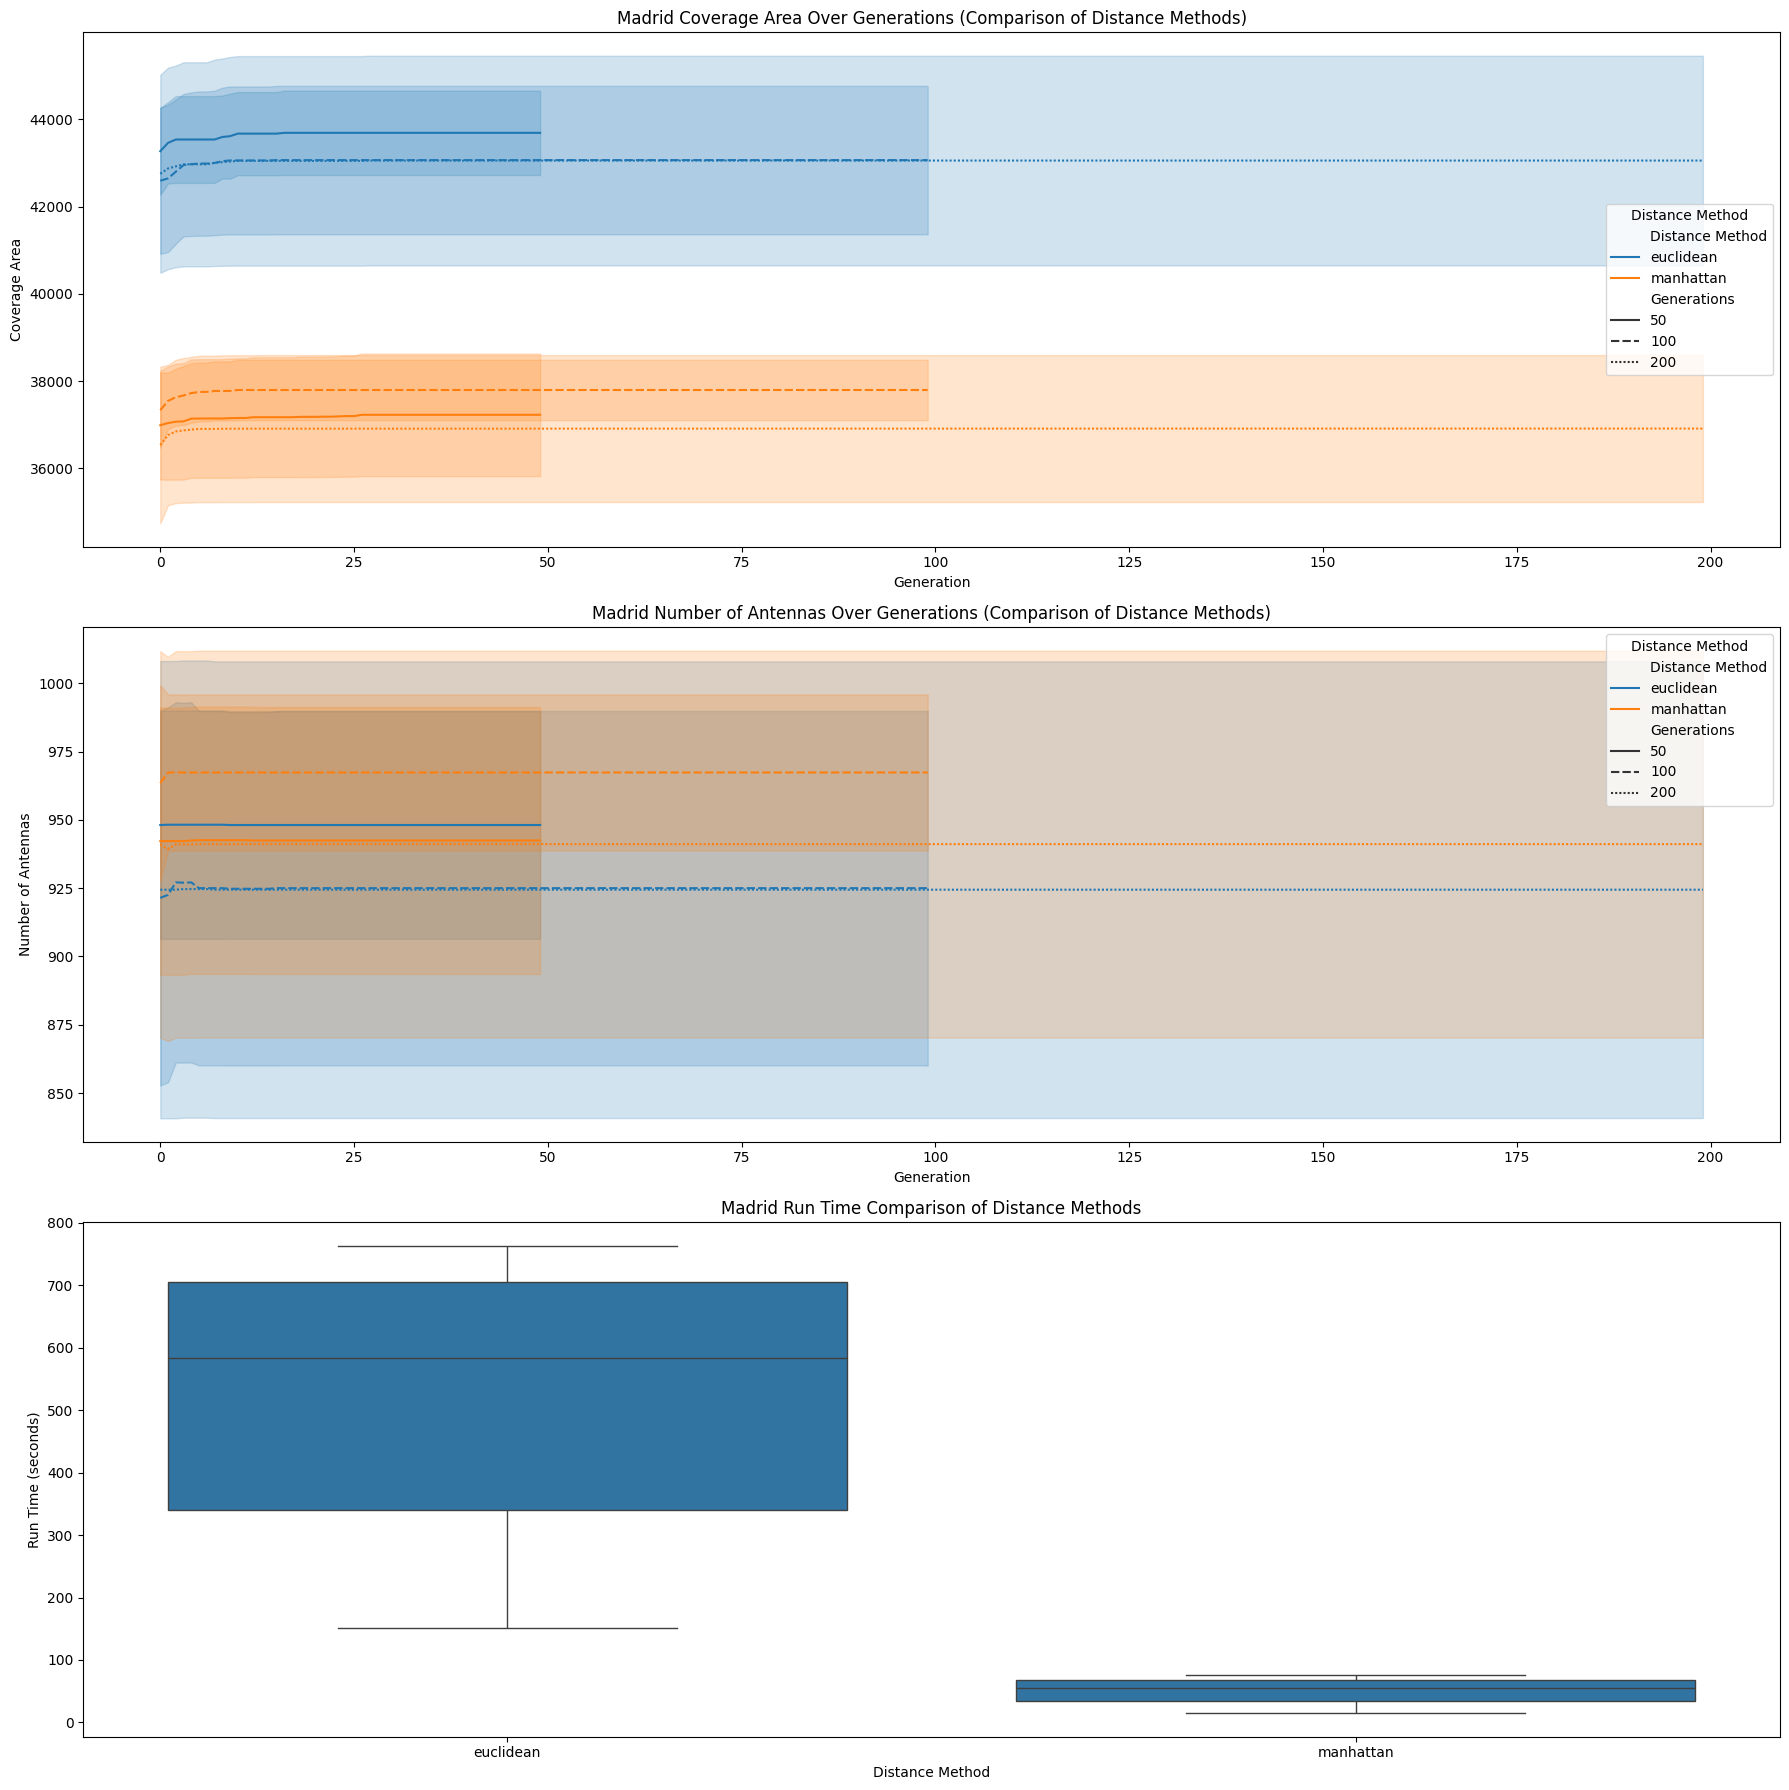

<ipython-input-170-35cba5812bd1>:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x='Generation', y='Coverage Area', hue='Distance Method', style='Generations', ci='sd')
<ipython-input-170-35cba5812bd1>:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x='Generation', y='Number of Antennas', hue='Distance Method', style='Generations', ci='sd')


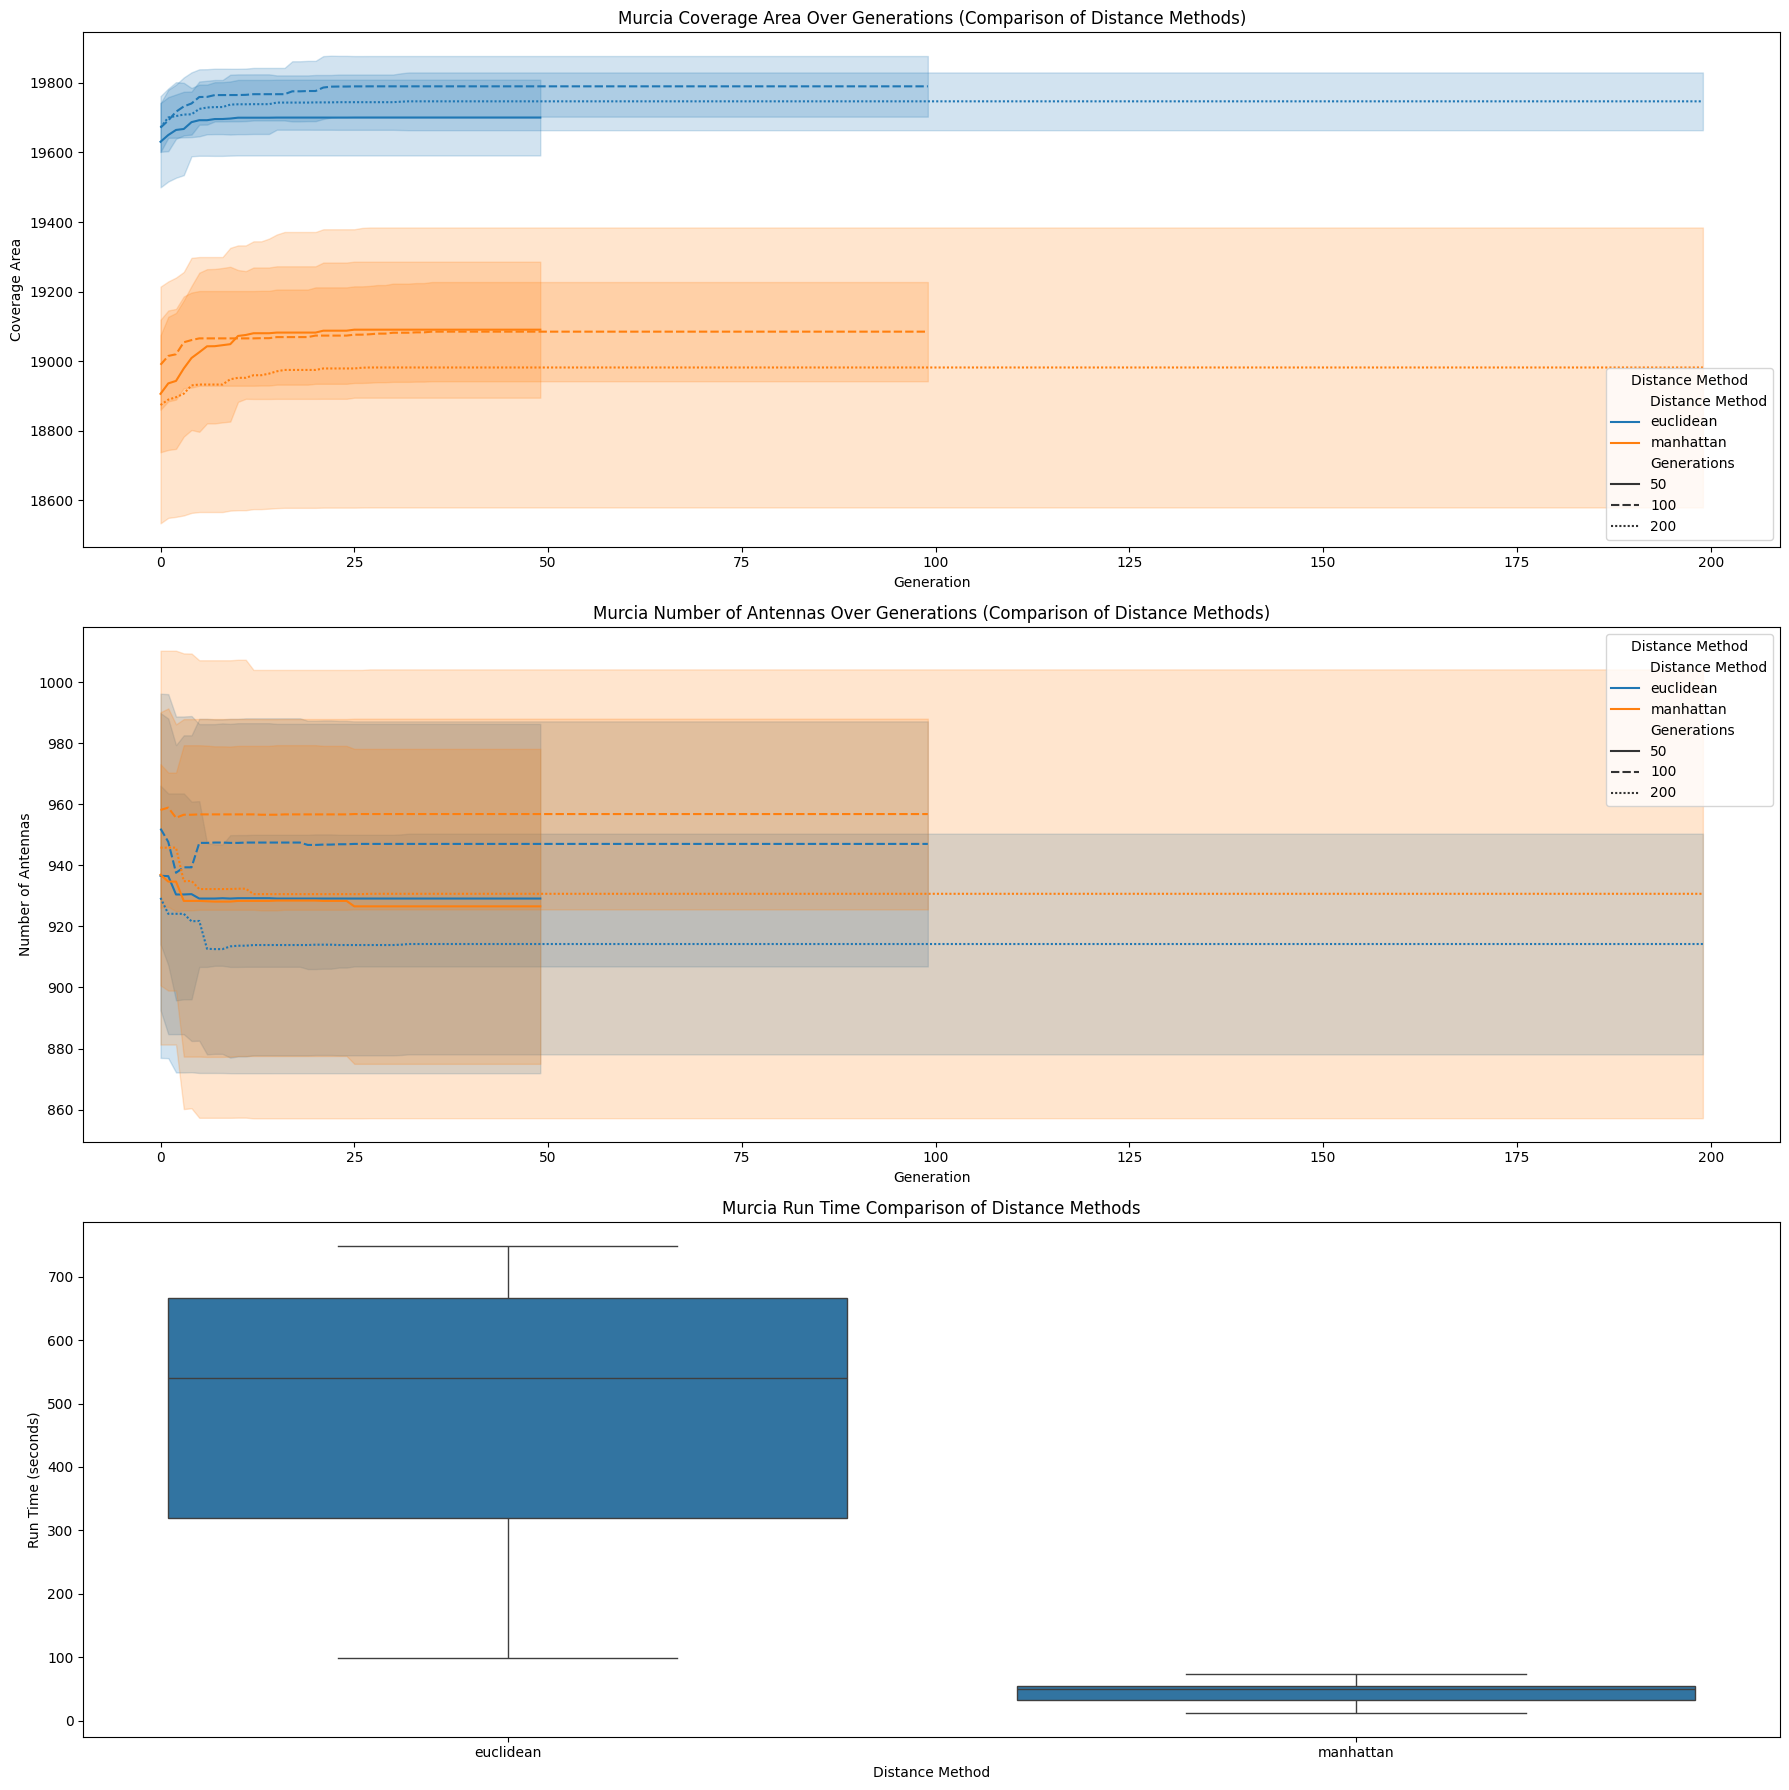

In [ ]:
# Plot summary results for Madrid with distance methods comparison
plot_comparison(madrid_results_with_distance, 'Madrid')

# Plot summary results for Murcia with distance methods comparison
plot_comparison(murcia_results_with_distance, 'Murcia')

In [ ]:
best_solution_madrid, best_fitness_madrid, best_distance_method_madrid = get_best_solution(madrid_results_with_distance)
best_solution_murcia, best_fitness_murcia, best_distance_method_murcia = get_best_solution(murcia_results_with_distance)

print("Best solution for Madrid:")
print("Best Fitness (Coverage Area, Number of Antennas):", best_fitness_madrid)
print("Antennas positions:", best_solution_madrid)
print("Distance Method:", best_distance_method_madrid)

print("\nBest solution for Murcia:")
print("Best Fitness (Coverage Area, Number of Antennas):", best_fitness_murcia)
print("Antennas positions:", best_solution_murcia)
print("Distance Method:", best_distance_method_murcia)

Best solution for Madrid:
Best Fitness (Coverage Area, Number of Antennas): (44957, 983)
Antennas positions: [(92, 6), (206, 192), (222, 164), (255, 183), (288, 51), (10, 24), (19, 91), (170, 49), (282, 126), (261, 43), (86, 140), (272, 129), (224, 65), (256, 64), (207, 31), (20, 23), (50, 20), (254, 185), (214, 79), (224, 12), (43, 141), (3, 32), (193, 65), (109, 189), (64, 3), (175, 108), (25, 70), (269, 149), (15, 53), (53, 40), (261, 63), (98, 90), (73, 176), (246, 26), (262, 77), (110, 109), (209, 17), (22, 51), (63, 81), (1, 113), (84, 72), (18, 162), (8, 54), (129, 26), (279, 43), (126, 145), (235, 197), (26, 0), (100, 166), (209, 57), (296, 96), (181, 127), (155, 113), (96, 16), (279, 26), (34, 146), (12, 121), (127, 148), (182, 174), (98, 61), (158, 18), (152, 125), (104, 44), (221, 129), (87, 14), (151, 7), (22, 94), (64, 134), (244, 30), (224, 22), (206, 189), (27, 188), (101, 170), (118, 150), (169, 110), (193, 57), (35, 136), (69, 23), (114, 155), (175, 84), (106, 70), (99

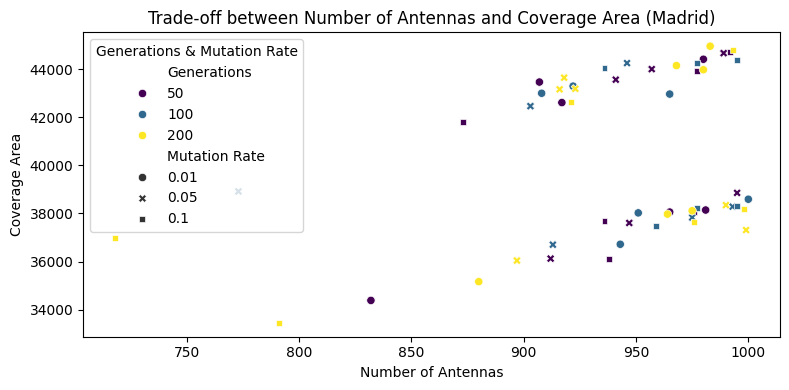

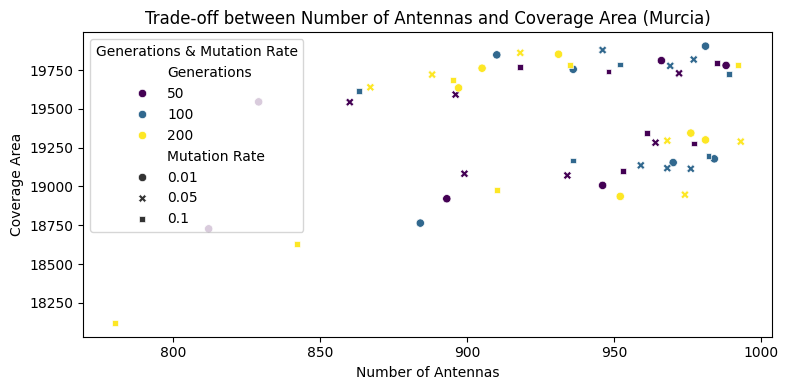

In [ ]:
# Plot the trade-off for Madrid
plot_tradeoff_between_antennas_and_coverage(madrid_results_with_distance, 'Madrid')

# Plot the trade-off for Murcia
plot_tradeoff_between_antennas_and_coverage(murcia_results_with_distance, 'Murcia')

In [ ]:
# Calculate and print correlation for Madrid
madrid_correlation = calculate_correlation(madrid_results_with_distance)
print("Correlation matrix for Madrid:")
print(madrid_correlation)

# Calculate and print correlation for Murcia
murcia_correlation = calculate_correlation(murcia_results_with_distance)
print("Correlation matrix for Murcia:")
print(murcia_correlation)

Correlation matrix for Madrid:
                    Coverage Area  Number of Antennas
Coverage Area            1.000000            0.293615
Number of Antennas       0.293615            1.000000
Correlation matrix for Murcia:
                    Coverage Area  Number of Antennas
Coverage Area            1.000000            0.316428
Number of Antennas       0.316428            1.000000


In [ ]:
# Perform sensitivity analysis for Madrid
madrid_coverage_sensitivity, madrid_antennas_sensitivity = sensitivity_analysis(madrid_results_with_distance)
print("Sensitivity analysis for Madrid:\n")
print("Coverage Area Sensitivity:")
print(madrid_coverage_sensitivity)
print("\nNumber of Antennas Sensitivity:")
print(madrid_antennas_sensitivity)

# Perform sensitivity analysis for Murcia
murcia_coverage_sensitivity, murcia_antennas_sensitivity = sensitivity_analysis(murcia_results_with_distance)
print("\n\nSensitivity analysis for Murcia:\n")
print("Coverage Area Sensitivity:")
print(murcia_coverage_sensitivity)
print("\nNumber of Antennas Sensitivity:")
print(murcia_antennas_sensitivity)


Sensitivity analysis for Madrid:

Coverage Area Sensitivity:
Generation
0      3346.844854
1      3314.378376
2      3330.083711
3      3351.363305
4      3338.090035
          ...     
195    3746.736555
196    3746.736555
197    3746.736555
198    3746.736555
199    3746.736555
Name: Coverage Area, Length: 200, dtype: float64

Number of Antennas Sensitivity:
Generation
0      59.541857
1      59.085427
2      58.487353
3      58.460819
4      58.464755
         ...    
195    75.610889
196    75.610889
197    75.610889
198    75.610889
199    75.610889
Name: Number of Antennas, Length: 200, dtype: float64


Sensitivity analysis for Murcia:

Coverage Area Sensitivity:
Generation
0      408.766244
1      410.719315
2      415.157951
3      408.052658
4      404.711412
          ...    
195    484.033205
196    484.033205
197    484.033205
198    484.033205
199    484.033205
Name: Coverage Area, Length: 200, dtype: float64

Number of Antennas Sensitivity:
Generation
0      45.117317
1  